In [ ]:
import pyspark, random

# Lecture 6A
# Introduction to Spark
## A MapReduce implementation -- and beyond
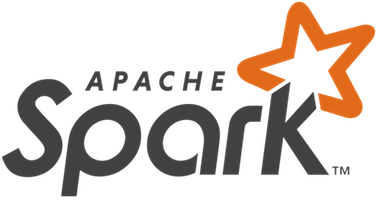

# Spark is MapReduce on Steroids!
- Like MapReduce, it automatically distributes your work over a cluster (and also your data, if you want)
- But is has some advantages over MapReduce that make it the go-to platform now.
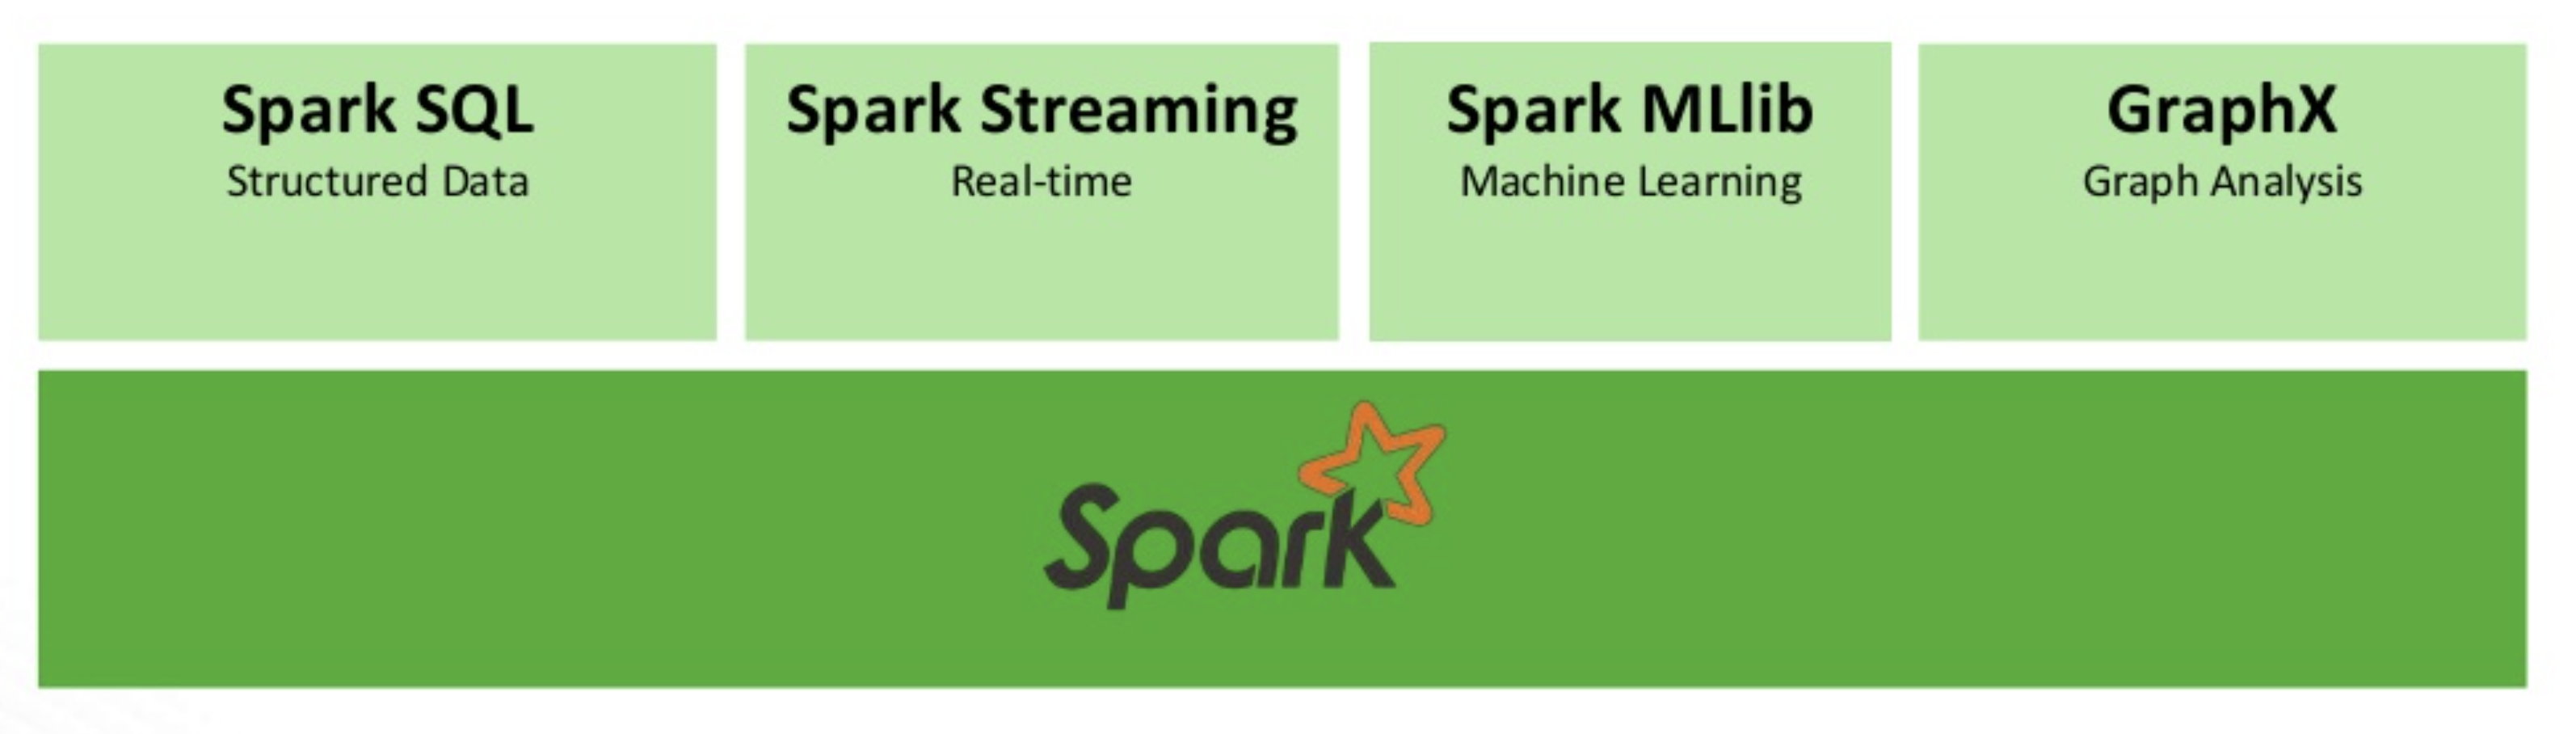


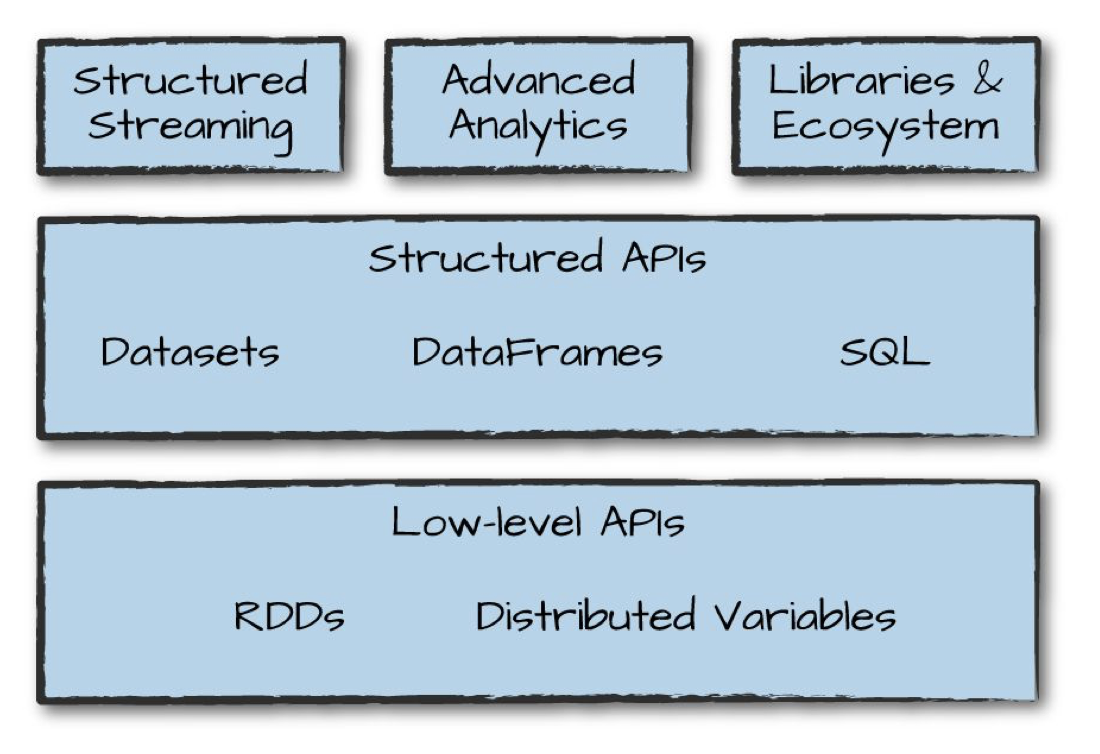

# Spark's advantage: Iteration
- Unlike MapReduce implementations it can _iterate_
- This means your computations can _revisit_ data
- This is crucial for e.g. machine learning

# Spark's advantage: Graph based computation
- Spark calculates a computational graph based on the work and available nodes
- This means it can apply optimizations; unlike MapReduce it can _order_ the computations
- This means it can also do _streaming_ analytics (i.e. never storing the data at all)

# Spark's advantage: DataFrames, No preferred datastore
* You can import data from any kind of source into Spark's dataframes
* E.g. import csv, xml, json
* Or build on huge existing stores in Hadoop Base (HBase), SQL databases or Distributed stores (Cassandra)

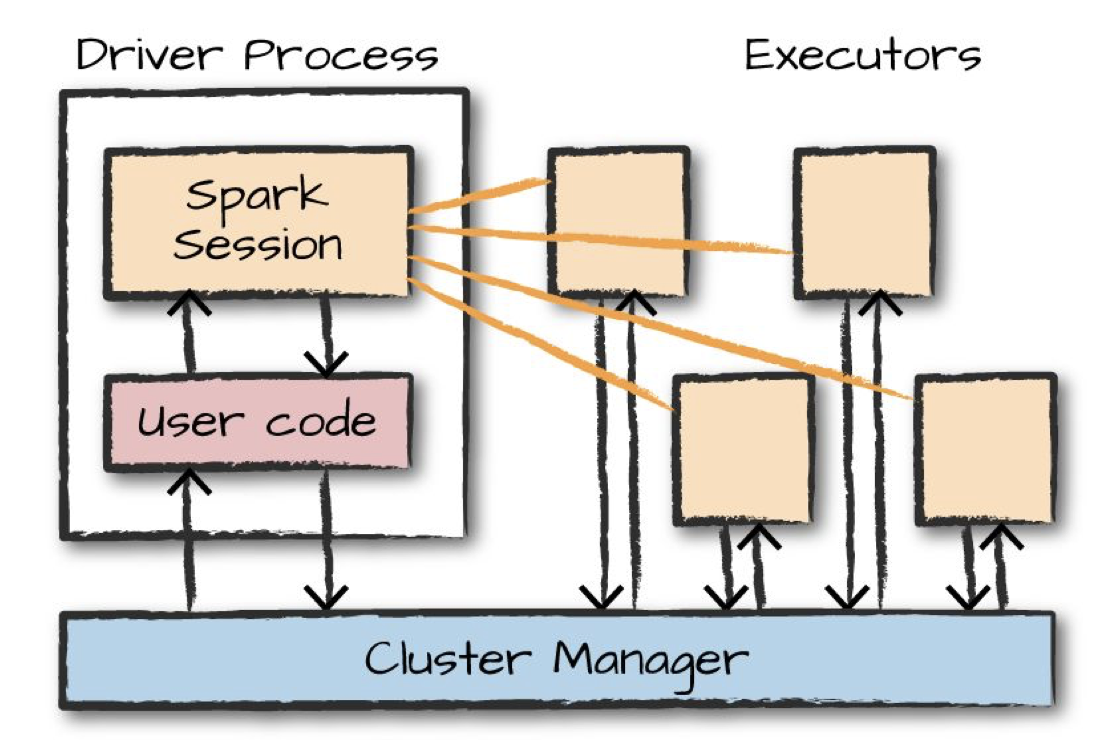

# Partitions
## Data is spread over the nodes in the cluster
- You can think of these as a bunch of rows from a dataframe
- These are called partitions
- They are also dynamically created according to the operations you carry out
- Note: these are _in memory_
- Also, they are usually set by the system; but if you specify them yourself, you can easily shoot yourself in the foot!


# Narrow vs Wide operations
- A "narrow" operation transforms one partition into one other (can be done on a node)
- A "wide" operation transforms partitions making use of other partitions

# Lazy Evaluation
- All transformations are queued until actually triggered by an _action_
- An action is something that "reports" on the transformed data
- for example, show() or count()
- Spark will analyze the entire pipeline to work on only the data needed at the end (by the action)

# Three kinds of actions
* Actions to view data in the console
* Actions to collect data to native objects in the respective language
* Actions to write to output data sources

# Work Plan
* Anytime you write a pipeline, you can ask Spark to "explain" (with the .explain() function) what it is that it will do to execute your pipeline. 
* This can be very helpful with debugging


In [1]:
import pyspark
from pyspark import SparkContext
sc = SparkContext('local[16]')

22/06/15 14:34:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/15 14:34:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/06/15 14:34:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/06/15 14:34:06 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/06/15 14:34:06 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


# See what's happening
http://localhost:4040

In [2]:
nums= sc.parallelize([1,2,3,4])

In [3]:
squared = nums.map(lambda x: x*x).collect()
for num in squared:
    print('%i ' % (num))

1 
4 
9 
16 


In [4]:
import random

NUM_SAMPLES = 100000000

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

count = sc.parallelize(range(0, NUM_SAMPLES)).filter(inside).count()

print("Pi is roughly %f" % (4.0 * count / NUM_SAMPLES))

Pi is roughly 3.141622


In [6]:
from pyspark.sql import Row
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
list_p = [('John',19),('Smith',29),('Adam',35),('Henry',50)]
rdd = sc.parallelize(list_p)
ppl = rdd.map(lambda x: Row(name=x[0], age=int(x[1])))
DF_ppl = sqlContext.createDataFrame(ppl)
DF_ppl.count()
DF_ppl.show()

+-----+---+
| name|age|
+-----+---+
| John| 19|
|Smith| 29|
| Adam| 35|
|Henry| 50|
+-----+---+



# A more sophisticated example

In [7]:
url = "https://bioinf.nl/~martijn/master/us_pop.csv"
from pyspark import SparkFiles
sc.addFile(url)
sqlContext = SQLContext(sc)
SparkFiles.get("us_pop.csv")

'/tmp/spark-1b04f280-2244-426f-9c46-ef841ba6f810/userFiles-0fc04289-d4b2-495e-87aa-6b94febe7008/us_pop.csv'

In [7]:
df = sqlContext.read.csv(SparkFiles.get('us_pop.csv'), header=True, inferSchema= True)

NameError: name 'SparkFiles' is not defined

In [8]:
df.printSchema()

NameError: name 'df' is not defined

In [10]:
df.show(5)

+---+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
|  x|age|workclass|fnlwgt|   education|educational-num|    marital-status|       occupation|relationship| race|gender|capital-gain|capital-loss|hours-per-week|native-country|income|
+---+---+---------+------+------------+---------------+------------------+-----------------+------------+-----+------+------------+------------+--------------+--------------+------+
|  1| 25|  Private|226802|        11th|              7|     Never-married|Machine-op-inspct|   Own-child|Black|  Male|           0|           0|            40| United-States| <=50K|
|  2| 38|  Private| 89814|     HS-grad|              9|Married-civ-spouse|  Farming-fishing|     Husband|White|  Male|           0|           0|            50| United-States| <=50K|
|  3| 28|Local-gov|336951|  Assoc-acdm|             12|Married-civ-spouse|  Protective-ser

In [11]:
df.select('age','fnlwgt').show(5)

+---+------+
|age|fnlwgt|
+---+------+
| 25|226802|
| 38| 89814|
| 28|336951|
| 44|160323|
| 18|103497|
+---+------+
only showing top 5 rows



In [12]:
df.describe().show()

+-------+------------------+------------------+-----------+------------------+------------+------------------+--------------+----------------+------------+------------------+------+------------------+-----------------+------------------+--------------+------+
|summary|                 x|               age|  workclass|            fnlwgt|   education|   educational-num|marital-status|      occupation|relationship|              race|gender|      capital-gain|     capital-loss|    hours-per-week|native-country|income|
+-------+------------------+------------------+-----------+------------------+------------+------------------+--------------+----------------+------------+------------------+------+------------------+-----------------+------------------+--------------+------+
|  count|             48842|             48842|      48842|             48842|       48842|             48842|         48842|           48842|       48842|             48842| 48842|             48842|            48842|  

In [13]:
df.select('age', 'fnlwgt').show(5)

+---+------+
|age|fnlwgt|
+---+------+
| 25|226802|
| 38| 89814|
| 28|336951|
| 44|160323|
| 18|103497|
+---+------+
only showing top 5 rows



In [14]:
df.groupBy("education").count().sort("count", ascending=True).show()

+------------+-----+
|   education|count|
+------------+-----+
|   Preschool|   83|
|     1st-4th|  247|
|     5th-6th|  509|
|   Doctorate|  594|
|        12th|  657|
|         9th|  756|
| Prof-school|  834|
|     7th-8th|  955|
|        10th| 1389|
|  Assoc-acdm| 1601|
|        11th| 1812|
|   Assoc-voc| 2061|
|     Masters| 2657|
|   Bachelors| 8025|
|Some-college|10878|
|     HS-grad|15784|
+------------+-----+



In [15]:
df.describe('capital-gain').show()

+-------+------------------+
|summary|      capital-gain|
+-------+------------------+
|  count|             48842|
|   mean|1079.0676262233324|
| stddev| 7452.019057655418|
|    min|                 0|
|    max|             99999|
+-------+------------------+



In [16]:
df.crosstab('age', 'education').sort('age_education').explain()

== Physical Plan ==
*(1) Sort [age_education#1356 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(age_education#1356 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#180]
   +- LocalTableScan [age_education#1356, 10th#1407L, 11th#1408L, 12th#1409L, 1st-4th#1410L, 5th-6th#1411L, 7th-8th#1412L, 9th#1413L, Assoc-acdm#1414L, Assoc-voc#1415L, Bachelors#1416L, Doctorate#1417L, HS-grad#1418L, Masters#1419L, Preschool#1420L, Prof-school#1421L, Some-college#1422L]




In [17]:
df.filter(df.age > 40).count()

20211

In [18]:
df.filter(df.education == "Preschool").count()

83

In [19]:
df.groupby('marital-status').agg({'capital-gain': 'mean'}).show()

+--------------------+------------------+
|      marital-status| avg(capital-gain)|
+--------------------+------------------+
|           Separated| 581.8424836601307|
|       Never-married|  384.382639449029|
|Married-spouse-ab...| 629.0047770700637|
|            Divorced| 793.6755615860094|
|             Widowed| 603.6442687747035|
|   Married-AF-spouse|2971.6216216216217|
|  Married-civ-spouse|1739.7006121810625|
+--------------------+------------------+



In [20]:
from pyspark.sql.functions import *
# 1 Select the column
age_square = df.select(col("age")**2)

# 2 Apply the transformation and add it to the DataFrame
df = df.withColumn("age_square", col("age")**2)

In [21]:
df.printSchema()

root
 |-- x: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- educational-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- age_square: double (nullable = true)



In [22]:
df.drop('race').columns

['x',
 'age',
 'workclass',
 'fnlwgt',
 'education',
 'educational-num',
 'marital-status',
 'occupation',
 'relationship',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'income',
 'age_square']

In [102]:
sc.stop()

# References
- <a href="https://spark.apache.org">Apache Spark Project</a>
- <a href="https://github.com/apache/spark/tree/master/examples/src/main/python">Python Examples</a>
- <a href="http://ampcamp.berkeley.edu/big-data-mini-course/data-exploration-using-spark.html">AMP camp</a>

## Books
<a href="https://www.bol.com/nl/p/spark-the-definitive-guide/9200000076847593/?suggestionType=featured_product&suggestedFor=spark%20def&originalSearchContext=media_all&originalSection=main">Spark: The Definitive Guide", O'Reilly Associates 2018, Bill Chambers & Matei Zaharia</a>